Using Theano backend.
1 #define _CUDA_NDARRAY_C
2 
3 #include <Python.h>
4 #include <structmember.h>
5 #include "theano_mod_helper.h"
6 
7 #include <numpy/arrayobject.h>
8 #include <iostream>
9 
10 #include "cuda_ndarray.cuh"
11 
12 #ifndef CNMEM_DLLEXPORT
13 #define CNMEM_DLLEXPORT
14 #endif
15 
16 #include "cnmem.h"
17 #include "cnmem.cpp"
18 
19 //If true, when there is a gpu malloc or free error, we print the size of allocated memory on the device.
20 #define COMPUTE_GPU_MEM_USED 0
21 
22 //If true, we fill with NAN allocated device memory.
23 #define ALLOC_MEMSET 0
24 
25 //If true, we print out when we free a device pointer, uninitialize a
26 //CudaNdarray, or allocate a device pointer
27 #define PRINT_FREE_MALLOC 0
28 
29 //If true, we do error checking at the start of functions, to make sure there
30 //is not a pre-existing error when the function is called.
31 //You probably need to set the environment variable
32 //CUDA_LAUNCH_BLOCKING=1, and/or modify the CNDA_THREAD_SYNC
33

664                          (unsigned long long)dims[i]);
665             return NULL;
666         }
667         total_elements*=dims[i];
668     }
669 
670     // total_elements now contains the size of the array, in reals
671     if (total_elements > (SIZE_MAX / sizeof(real))){
672         PyErr_Format(PyExc_RuntimeError,
673                      "Can't store in size_t for the bytes requested %llu * 4",
674                      (unsigned long long)total_elements);
675         return NULL;
676     }
677     size_t total_size = total_elements * sizeof(real);
678 
679     CudaNdarray* rval = (CudaNdarray*)CudaNdarray_New();
680     if (!rval)
681     {
682         PyErr_SetString(PyExc_RuntimeError, "CudaNdarray_ZEROS: call to New failed");
683         return NULL;
684     }
685 
686     if (CudaNdarray_alloc_contiguous(rval, n, dims))
687     {
688         PyErr_SetString(PyExc_RuntimeError, "CudaNdarray_ZEROS: allocation failed.");
689         Py_DECREF(rval);
690         return NULL

1540 
1541 template <int operator_num>
1542 __global__ void k_ielem_3(const int d0, const int d1, const int d2,
1543         float* a, const int sA0, const int sA1, const int sA2,
1544         const float* b, const int sB0, const int sB1, const int sB2){
1545     for (int i0 = blockIdx.x; i0 < d0; i0 += gridDim.x){
1546         for (int i1 = blockIdx.y; i1 < d1; i1 += gridDim.y){
1547             for (int i2 = threadIdx.x; i2 < d2; i2 += blockDim.x){
1548                 switch (operator_num)
1549                 {
1550                   case IADD:
1551                     a[i0*sA0 + i1*sA1 + i2*sA2] += b[i0*sB0 + i1*sB1 + i2*sB2];
1552                     break;
1553                   case IDIV:
1554                     a[i0*sA0 + i1*sA1 + i2*sA2] /= b[i0*sB0 + i1*sB1 + i2*sB2];
1555                     break;
1556                   case CPY:
1557                     a[i0*sA0 + i1*sA1 + i2*sA2] = b[i0*sB0 + i1*sB1 + i2*sB2];
1558                     break;
1559                 }
1560 

2647     return 0;
2648 }
2649 
2650 
2651 PyMappingMethods CudaNdarrayMappingMethods = {
2652     CudaNdarray_len, //lenfunc mp_length;               __len__
2653     CudaNdarray_Subscript, //binaryfunc mp_subscript;   __getitem__
2654     CudaNdarray_setitem //objobjargproc mp_ass_subscript;                __setitem__
2655 };
2656 
2657 ////////////////////
2658 //
2659 ////////////////////
2660 
2661 static PyObject *
2662 CudaNdarray_get_shape(CudaNdarray *self, void *closure)
2663 {
2664     if (self->nd < 0)
2665     {
2666         PyErr_SetString(PyExc_ValueError, "CudaNdarray not initialized");
2667         return NULL;
2668     }
2669     PyObject * rval = PyTuple_New(self->nd);
2670     for (int i = 0; i < self->nd; ++i)
2671     {
2672         if (!rval || PyTuple_SetItem(rval, i, PyInt_FromLong(CudaNdarray_HOST_DIMS(self)[i])))
2673         {
2674             Py_XDECREF(rval);
2675             return NULL;
2676         }
2677 
2678     }
2679     return rval;
2680 }
2681 
2

3627     }
3628 
3629 #if PY_MAJOR_VERSION == 3
3630     m = PyModule_Create(&cuda_ndarray_moduledef);
3631 #else
3632     m = Py_InitModule3(CNDA_MOD_NAME, module_methods, CNDA_DOCSTRING);
3633 #endif
3634 
3635     if (m == NULL) {
3636 #if PY_MAJOR_VERSION == 3
3637         return NULL;
3638 #else
3639         return;
3640 #endif
3641     }
3642 
3643     Py_INCREF(&CudaNdarrayType);
3644     PyModule_AddObject(m, "CudaNdarray", (PyObject *)&CudaNdarrayType);
3645 #if COMPUTE_GPU_MEM_USED
3646     for(int i=0;i<TABLE_SIZE;i++){
3647         _alloc_size_table[i].ptr=NULL;
3648         _alloc_size_table[i].size=0;
3649     }
3650 #endif
3651     //    cublasInit();
3652     //if (0&&CUBLAS_STATUS_SUCCESS != cublasGetError())
3653     //{
3654         //std::cerr << "WARNING: initcuda_ndarray: error initializing device\n";
3655     //}
3656     if (0) //TODO: is this necessary?
3657     {
3658         int deviceId = 0; // TODO: what number goes here?
3659         cudaSetDevice(deviceId

4810     if (self->nd != A->nd)
4811     {
4812         PyErr_Format(PyExc_TypeError, "Rank mismatch in CudaNdarray_sum: %i vs %i", self->nd, A->nd);
4813         return -1;
4814     }
4815     for (int i = 0; i < self->nd; ++i)
4816     {
4817         if ((CudaNdarray_HOST_DIMS(self)[i] > 1) && (CudaNdarray_HOST_DIMS(self)[i] != CudaNdarray_HOST_DIMS(A)[i]))
4818         {
4819             PyErr_Format(PyExc_TypeError, "Dimension mismatch in CudaNdarray_sum: self->dim[%i] == %i , A->dim[%i] = %i",
4820                     i, CudaNdarray_HOST_DIMS(self)[i], i, CudaNdarray_HOST_DIMS(A)[i]);
4821             return -1;
4822         }
4823     }
4824 
4825     int n_summations = (unsigned int)CudaNdarray_SIZE(self);
4826     if (verbose)
4827     {
4828         std::cerr << "reduce_sum n_summations " << n_summations  << '\n';
4829         std::cerr << "reduce_sum nd " << self->nd  << '\n';
4830         fprint_CudaNdarray(stderr, A);
4831         fprint_CudaNdarray(stderr, self);
4832     

nvcc warning : The 'compute_20', 'sm_20', and 'sm_21' architectures are deprecated, and may be removed in a future release (Use -Wno-deprecated-gpu-targets to suppress warning).
nvcc fatal   : Cannot find compiler 'cl.exe' in PATH

['nvcc', '-shared', '-O3', '-Xlinker', '/DEBUG', '-D HAVE_ROUND', '-m64', '-Xcompiler', '-DCUDA_NDARRAY_CUH=mc72d035fdf91890f3b36710688069b2e,-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION,/Zi,/MD', '-I"C:\\Users\\raul\\Anaconda3\\lib\\site-packages\\theano\\sandbox\\cuda"', '-I"C:\\Users\\raul\\Anaconda3\\lib\\site-packages\\numpy\\core\\include"', '-I"C:\\Users\\raul\\Anaconda3\\include"', '-I"C:\\Users\\raul\\Anaconda3\\lib\\site-packages\\theano\\gof"', '-L"C:\\Users\\raul\\Anaconda3\\libs"', '-L"C:\\Users\\raul\\Anaconda3"', '-o', 'C:\\Users\\raul\\AppData\\Local\\Theano\\compiledir_Windows-10-10.0.16299-SP0-Intel64_Family_6_Model_94_Stepping_3_GenuineIntel-3.6.1-64\\cuda_ndarray\\cuda_ndarray.pyd', 'mod.cu', '-lcublas', '-lpython36', '-lcudart']
One Class

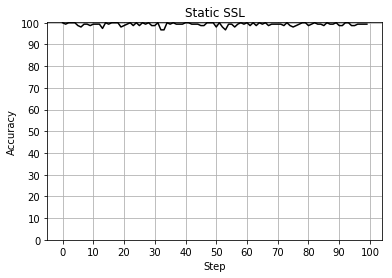

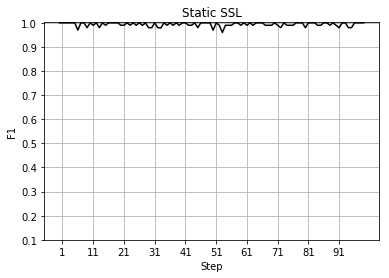




METHOD: Sliding LSTM as classifier (Long-short term memory)
Error when checking input: expected lstm_1_input to have 3 dimensions, but got array with shape (800, 2)
Method: Level IW
Execution time:  0.3711151065067929
Average MCC:  -0.000156268648432
Average macro-F1: 0.4972992852476316
Average Accuracy:  99.967105
Standard Deviation:  0.170927433945
Variance:  0.029216187675


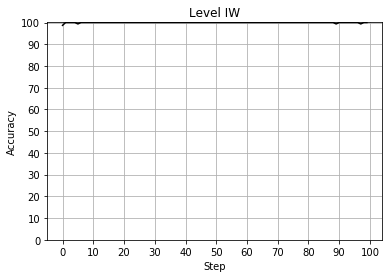

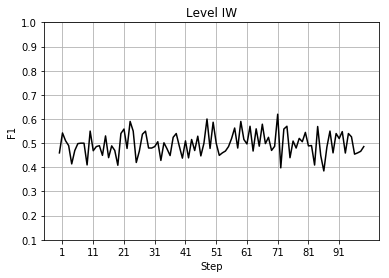

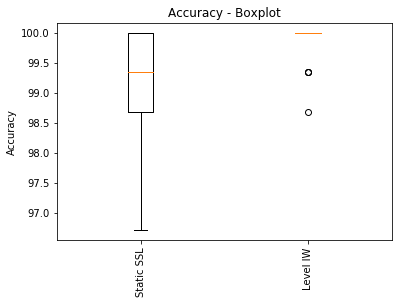

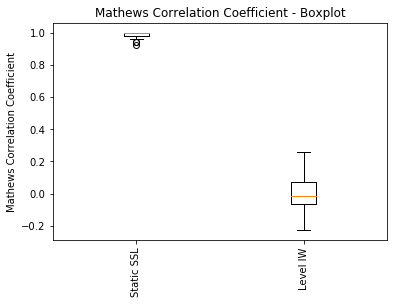

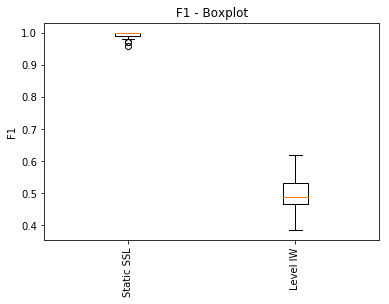

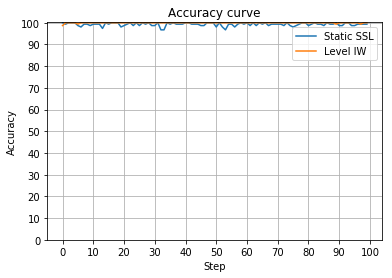

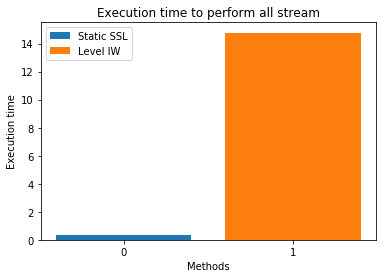

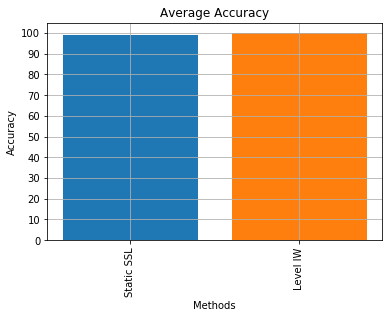

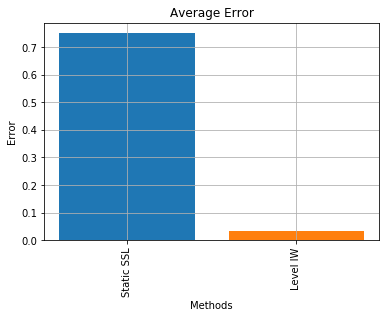

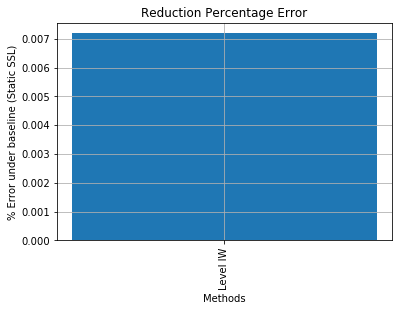

In [1]:
import sys
import os
from pathlib import Path
os.chdir(Path(os.getcwd()).resolve().parents[1])

import setup
import numpy as np
from methods import runExperiments
from methods import static_classifier
from methods import amanda_dynamic
from methods import amanda_fixed
from methods import incremental_LN
from methods import deslizante_LN
from methods import compose_gmm_version
from methods import lstm


class Experiment():
     def __init__(self, method, K=None, excludingPercentage=None, densityFunction=None, clfName=None):
        self.method = method
        self.clfName = clfName
        self.densityFunction=densityFunction
        self.excludingPercentage = excludingPercentage
        self.K_variation = K


def loadLevelResults(path, sep, key, steps):
    originalAccs, F1s, time = setup.loadLevelIwBoxplotResults(path, sep)
    predictions = F1s[key]
    predictions = [ np.asarray(predictions[i::steps]) for i in range(steps) ]
    
    #print("predictions",np.shape(predictions))
    #print("originalAccs",key,originalAccs[key])
    return predictions, originalAccs[key], time[key]


def main():
    experiments = {}
    is_windows = sys.platform.startswith('win')
    sep = '\\'

    if is_windows == False:
        sep = '/'

    path = os.getcwd()+sep+'data'+sep
    
    # SETTINGS
    sslClassifier = 'lp' # lp = label propagation, rf = random forests, nb = naive bayes, knn = k-nn, sgd = stochastic gradient descent
    steps = 100
    poolSize = None
    isBatchMode = True # False = Stream
    isBinaryClassification = True
    isImbalanced = False
    externalResults = []
    
    # Load dataset
    dataValues, dataLabels, description = setup.loadCDT(path, sep)
    
    # Only 5% of initial labeled data - Extreme verification latency scenario
    labeledData = int(0.05*len(dataLabels))
    #'''
    # Static SSL
    experiments[0] = Experiment(static_classifier, 2, clfName=sslClassifier)
    
    # Sliding SSL
    #experiments[1] = Experiment(deslizante_LN, 2, clfName=sslClassifier)
    
    # Incremental SSL
    #experiments[2] = Experiment(incremental_LN, 2, clfName=sslClassifier)
    
    # Proposed Method 1 (AMANDA - Fixed core extraction percentage)
    #experiments[3] = Experiment(amanda_fixed, 2, 0.85, "kde", clfName=sslClassifier)

    # Proposed method 2 (AMANDA - Dynamic core extraction percentage)
    #experiments[4] = Experiment(amanda_dynamic, 4, None, "kde", clfName=sslClassifier)

    # COMPOSE GMM (Python version)
    #experiments[5] = Experiment(compose_gmm_version, 2)
    
    # levelIw matlab results
    predictionsLevelIw, originalAccsLevelIw, timeLevelIw = loadLevelResults(path, sep, '1CDT', steps)
    externalResults.append({"name":"Level IW", "predictions":predictionsLevelIw, "accuracies":originalAccsLevelIw, "time":timeLevelIw})
    #'''
    # Upper-bound
    experiments[6] = Experiment(lstm, 2)
    
    # Run experiments
    runExperiments.run(dataValues, dataLabels, description, isBinaryClassification, isImbalanced, 
                       experiments, steps, labeledData, isBatchMode, poolSize, externalResults)
    

if __name__ == "__main__":
    main()